# Readout fidelity corrections

We make corrections to the qubit projective measurements by performing an Interative Bayesian Update (IBU) method. The method is an iterative solver that effectively performs matrix inversion, but would not violate the positivity constraint of the probability distribution. https://www.nature.com/articles/s41534-020-00309-7

In [1]:
import numpy as np
import matplotlib.pyplot as plt

The confusion matrix of the joint readout of the two qubits is measured as

![readout_fidelity_Q1Q2](./Figures/readout_fidelity_Q1Q2.png "Readout Fidelity Q1Q2")

In [2]:
# The numpy array representation of the confusion matric
R = np.array([
    [0.911, 0.052, 0.034, 0.002],
    [0.068, 0.920, 0.004, 0.042],
    [0.019, 0.001, 0.892, 0.055],
    [0.002, 0.027, 0.071, 0.900]
])

We demonstrate the readout fidelity correction by importing some data

In [3]:
# IBU_correction
def IBU_correction(R, m, N=10):
    shape = m.shape[:-1]
    n_m, n_t = R.shape
    m = m.reshape((-1, n_m))

    R_mask = np.any(R != 0.0, axis=1)
    R = R[R_mask, :]
    m = m[:, R_mask]
    m_row_sum = np.sum(m, axis=1).reshape((-1, 1))
    m /= m_row_sum

    t = np.full((len(m), n_t), 1 / n_t)
    for _ in range(N):
        t = np.tensordot((m / np.tensordot(t, R, (1, 1))), R, (1, 0)) * t
    return t.reshape(shape + (n_t,))

Maximum error between the corrected data and the data loaded from the csv file = 0.003934478551242975  (should be 10^-3 order of magnitude)


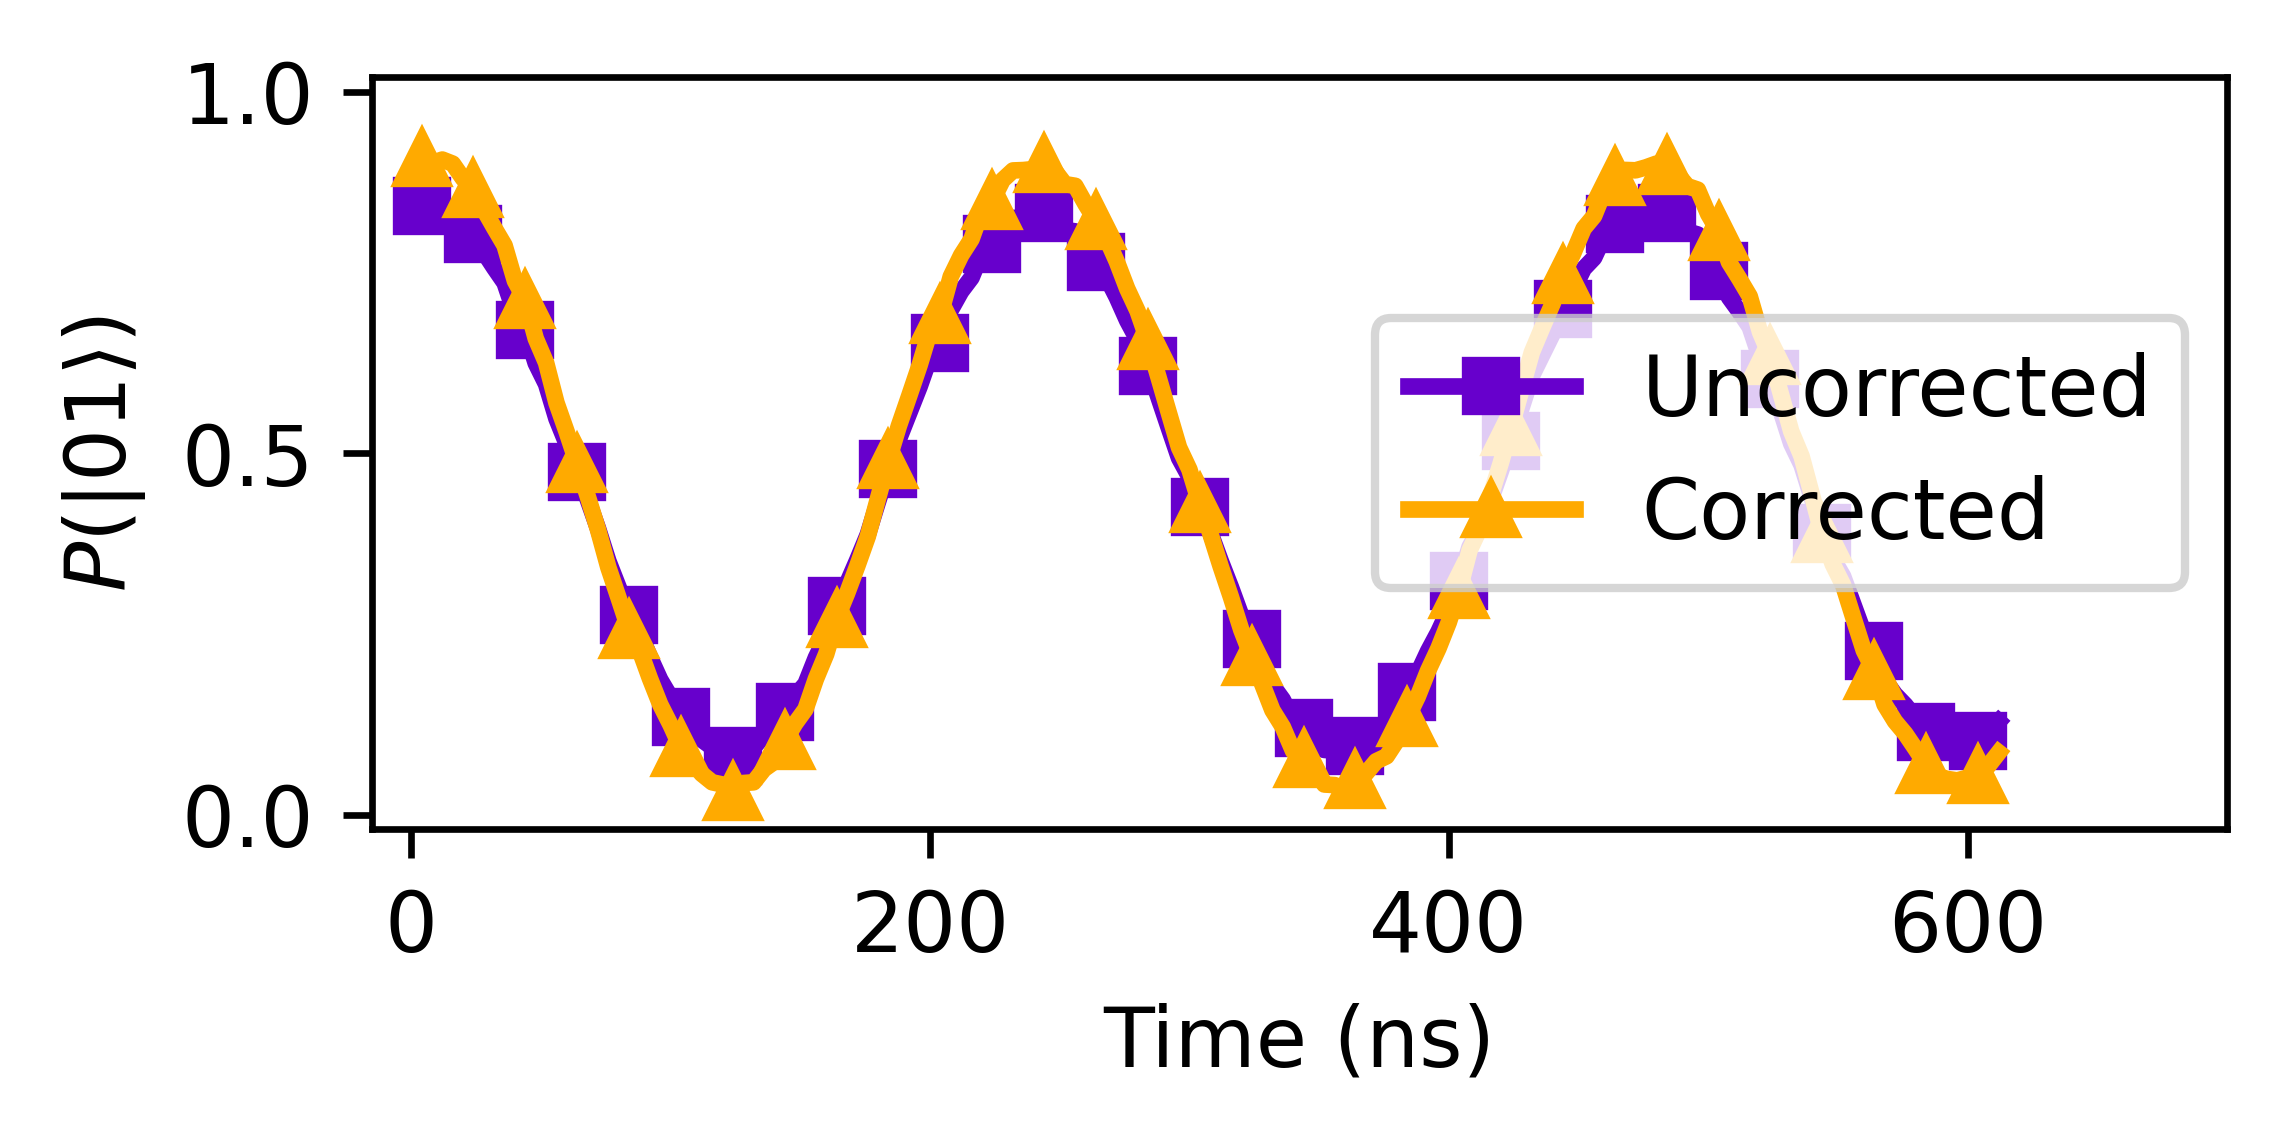

In [26]:
# The data loaded from the csv files are probability distributions after correction.
t_list_Uz = np.loadtxt(r'Data/singlet_Ux_t_list_1218.csv', delimiter=",", skiprows=1)
P_list_Uz = np.loadtxt(r'Data/singlet_Ux_P_1218.csv', delimiter=",", skiprows=1)

# By multipliying the confusion matrix with the loaded data, we recover the uncorrected probability distribution
P_uncorrected = np.einsum(R, [0, 1], P_list_Uz, [2, 1], [2, 0])
# Obtain the corrected probabilityu distribution by applying the function IBU_correction
P_corrected = IBU_correction(R, P_uncorrected)

# Sanity check: The error between corrected data and the data loaded from the csv file (should be 10^-3 order of magnitude)
print(f"Maximum error between the corrected data and the data loaded from the csv file = {np.max(np.abs(P_corrected - P_list_Uz))}  (should be 10^-3 order of magnitude)")

purple = '#6700CC'
orange = '#FFAA00'
gray = '#777777'

fig, ax = plt.subplots(figsize=(4, 2), dpi=600)
plt.plot(t_list_Uz, P_uncorrected[:, 1], color=purple, marker='s', label='Uncorrected', linewidth=2, markevery=5)
plt.plot(t_list_Uz, P_corrected[:, 1], color=orange, marker='^', label='Corrected', linewidth=2, markevery=5)
plt.xlim(-15, 700)
plt.ylim(-0.02, 1.02)
plt.xlabel('Time (ns)')
plt.ylabel(r'$P(|01\rangle)$')
plt.legend()
fig.tight_layout()
plt.show()

In [27]:
fig.savefig(r"./Figures/readout_fidelity_correction.png")